In [1]:
import os, sys, pandas as pd, wfdb, tqdm, pickle, scipy, time, seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt, librosa
from scipy.signal import spectrogram
from scipy import interpolate
import torch, torchvision, torch.nn as nn
import numpy as np, librosa
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import numba
from tqdm import tqdm, trange, tgrange
import random
from IPython.display import Audio
from torchsummary import summary
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
waveform_path = '/N/project/waveform_mortality/shared/datasets/waveform_datasets/mimic-iii-waveform-database-1.0-full/mimic3wdb-matched-1.0.physionet.org/matched/matched/'

In [3]:
s = time.time()
signals, fields = wfdb.rdsamp(record_name= os.path.join(waveform_path, 'p05', 'p050034', 'p050034-2130-01-27-14-47'), sampfrom= 3500, sampto= 16500)
e = time.time()

In [4]:
sig = signals[:, 0]

In [5]:
fields['sig_name']

['II', 'III', 'AVR', 'V', 'RESP', 'PLETH', 'ABP']

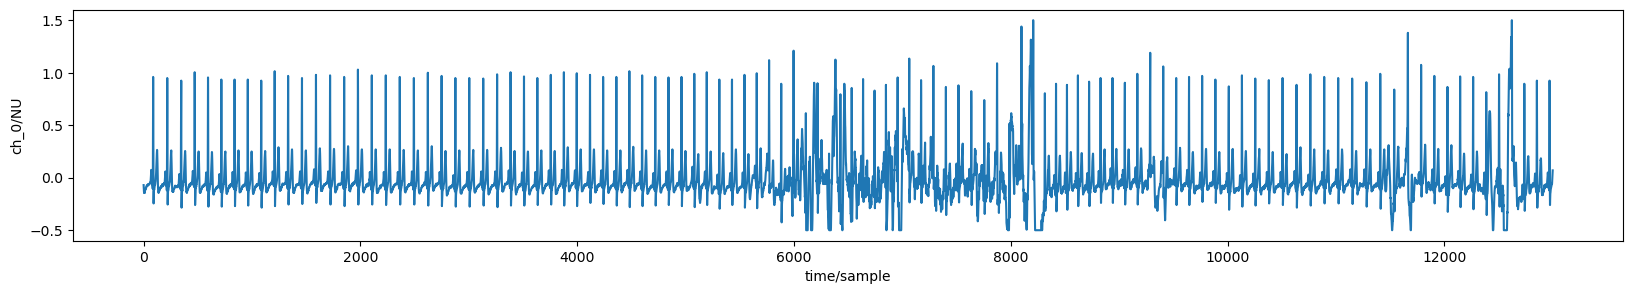

In [6]:
wfdb.plot_items(signal= sig, fs= fields['fs'], figsize= (20, 3))

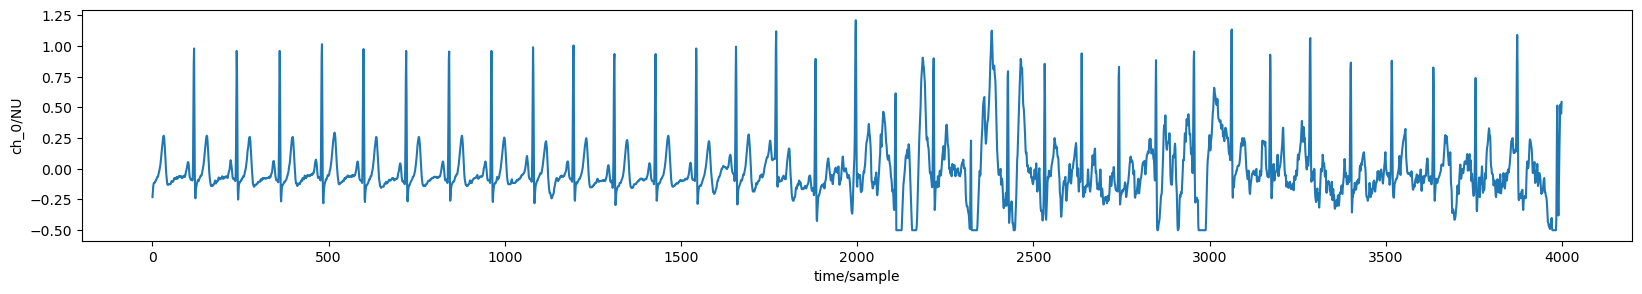

In [7]:
wfdb.plot_items(signal= sig[4000: 8000], fs= fields['fs'], figsize= (20, 3))

In [8]:
f, t, zxx = scipy.signal.stft(sig, nperseg= 125, noverlap= 95, nfft= 375)
phase = zxx / np.abs(zxx)
zxx = np.abs(zxx)

<Axes: >

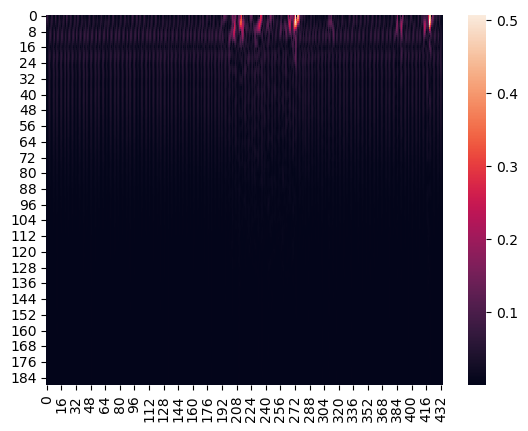

In [9]:
sns.heatmap(zxx)

<Axes: >

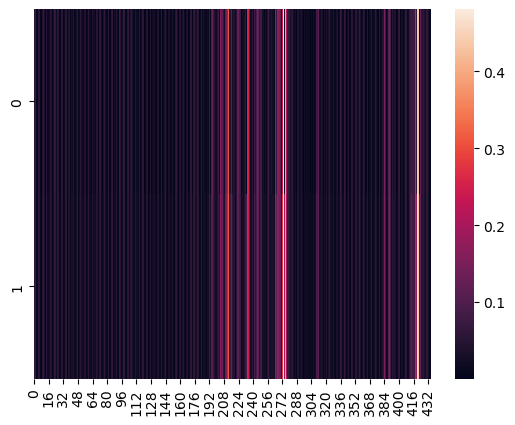

In [10]:
# Low frequency Noise
sns.heatmap(zxx[:2, :])

<Axes: >

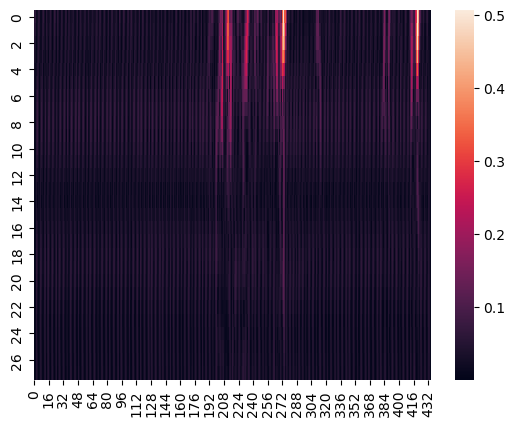

In [11]:
sns.heatmap(zxx[2:30, :])

In [12]:
phase.shape

(188, 435)

In [13]:
clean = phase[2:30, :] * zxx[2:30, :]

In [14]:
_, clean_time = scipy.signal.istft(clean, nperseg= 125, noverlap= 95, nfft= 375, fs= 125)

In [15]:
clean_time.shape

(13021,)

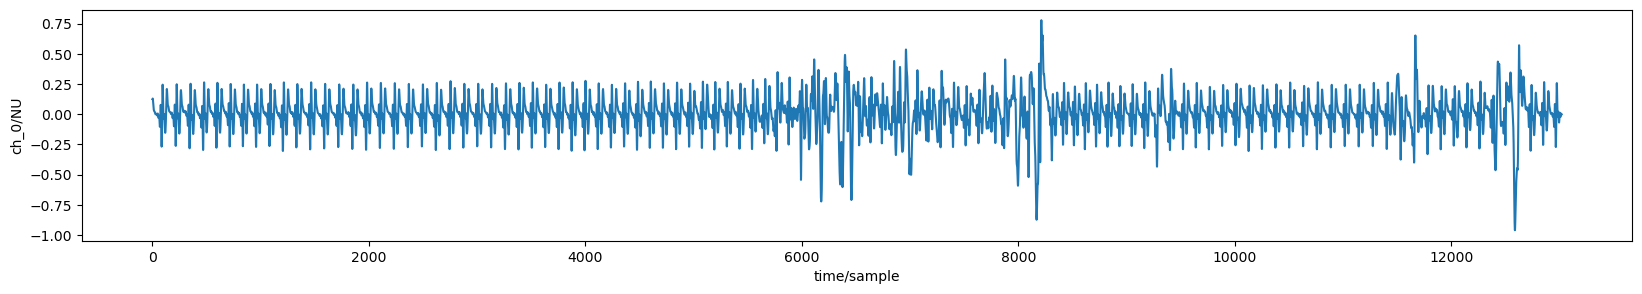

In [16]:
wfdb.plot_items(signal= clean_time, fs= fields['fs'], figsize= (20, 3))

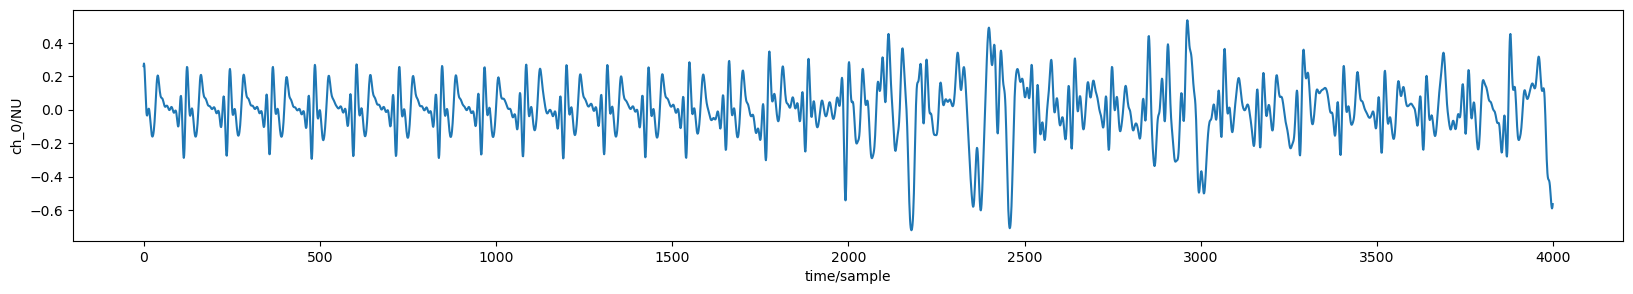

In [17]:
wfdb.plot_items(signal= clean_time[4000: 8000], fs= fields['fs'], figsize= (20, 3))

### Median Filter

In [18]:
lowpassed = scipy.signal.medfilt(sig, kernel_size= fields['fs'])
highpassed = sig - lowpassed

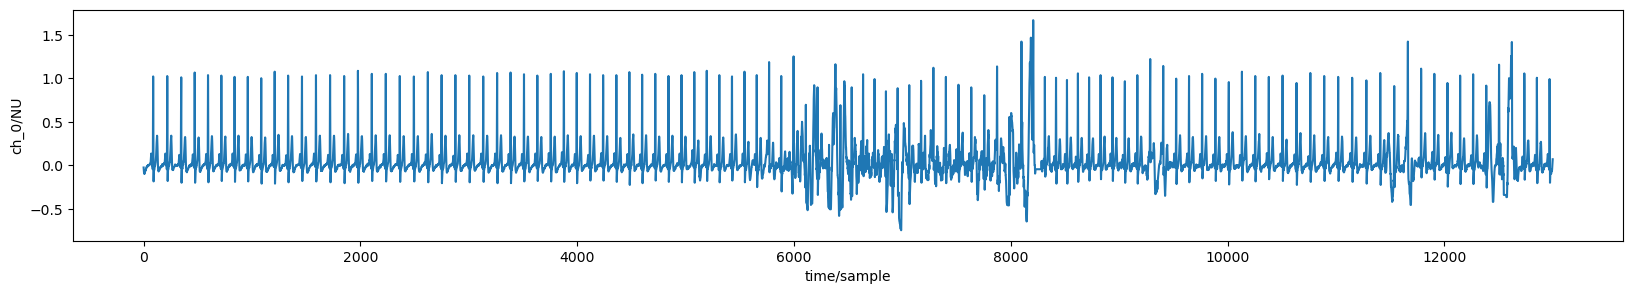

In [19]:
wfdb.plot_items(signal= highpassed, fs= fields['fs'], figsize= (20, 3))

### Butterworth Filter

#### Filter out low frequency i.e Baseline Wander Removal

In [20]:
lowpass = scipy.signal.butter(1, 0.5, btype='lowpass', fs= 125, output='sos')
lowpassed = scipy.signal.sosfilt(lowpass, sig)
highpassed = sig - lowpassed

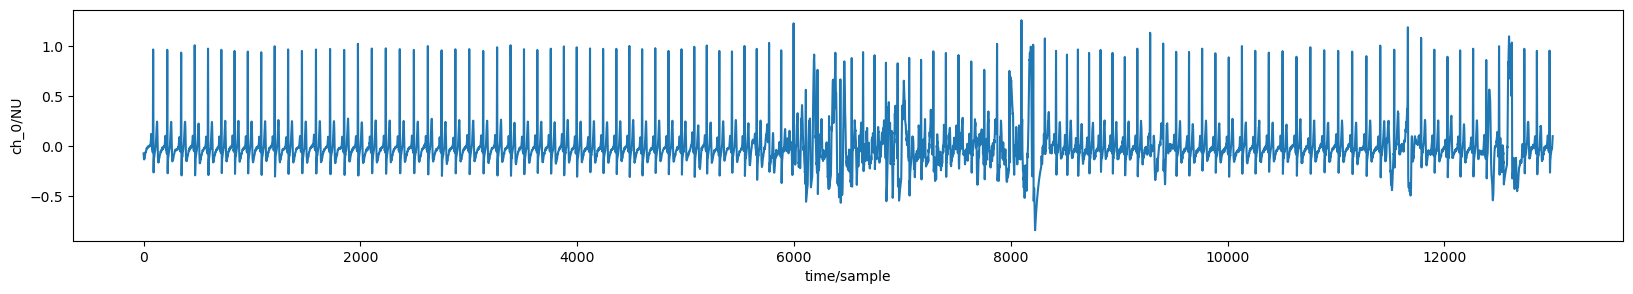

In [21]:
wfdb.plot_items(signal= highpassed, fs= fields['fs'], figsize= (20, 3))

#### Filter out very high frequency

In [22]:
lowpass = scipy.signal.butter(1, 10, btype='lowpass', fs= 125, output='sos')
lowpassed = scipy.signal.sosfilt(lowpass, sig)

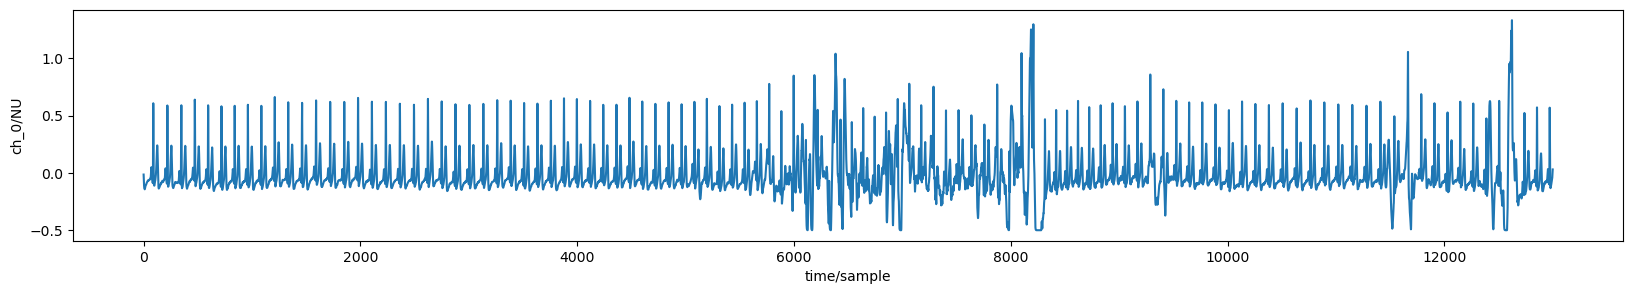

In [23]:
wfdb.plot_items(signal= lowpassed, fs= fields['fs'], figsize= (20, 3))

#### Filter out low followed by High frequency

In [24]:
# Median Filtering removes very low frequency
lowpassed = scipy.signal.medfilt(sig, kernel_size= fields['fs'])
highpassed = sig - lowpassed

# High Frequency removal
lowpass = scipy.signal.butter(1, 10, btype='lowpass', fs= 125, output='sos')
lowpassed = scipy.signal.sosfilt(lowpass, highpassed)

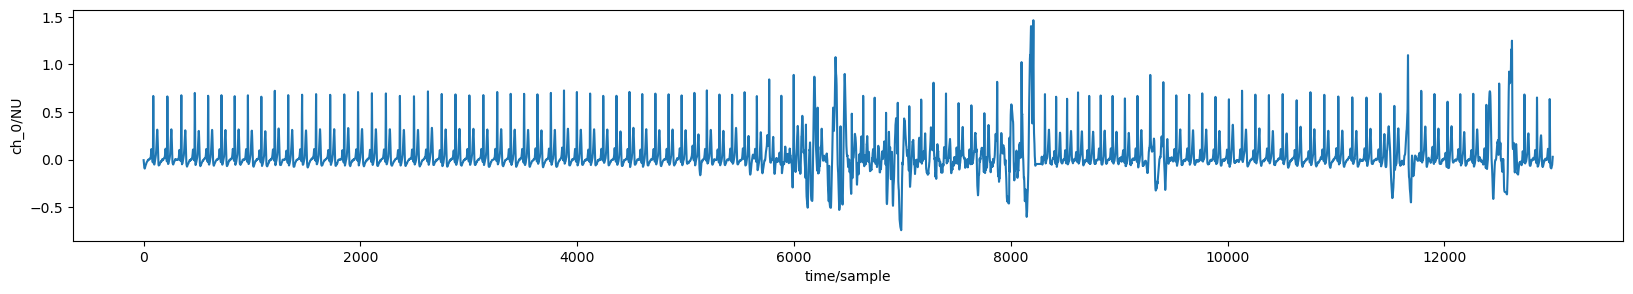

In [25]:
wfdb.plot_items(signal= lowpassed, fs= fields['fs'], figsize= (20, 3))

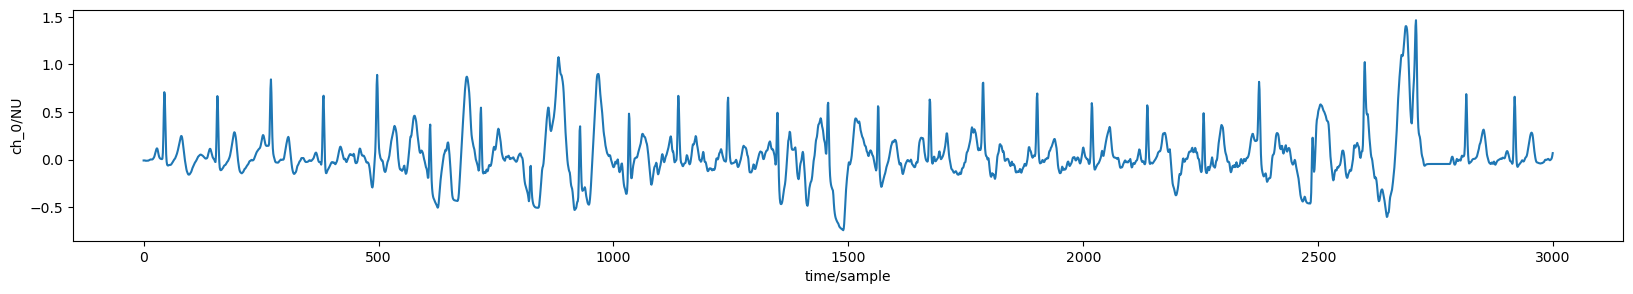

In [26]:
wfdb.plot_items(signal= lowpassed[5500 : 8500], fs= fields['fs'], figsize= (20, 3))

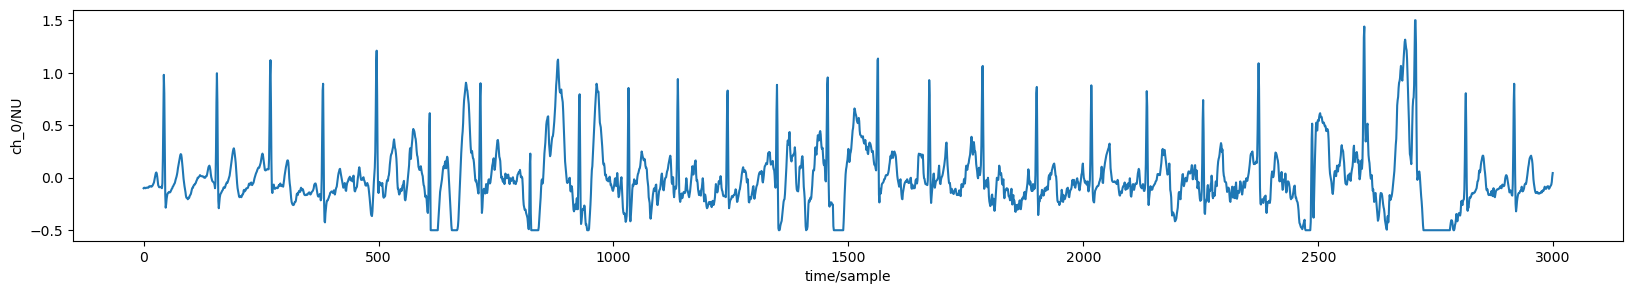

In [27]:
wfdb.plot_items(signal= sig[5500: 8500], fs= fields['fs'], figsize= (20, 3))

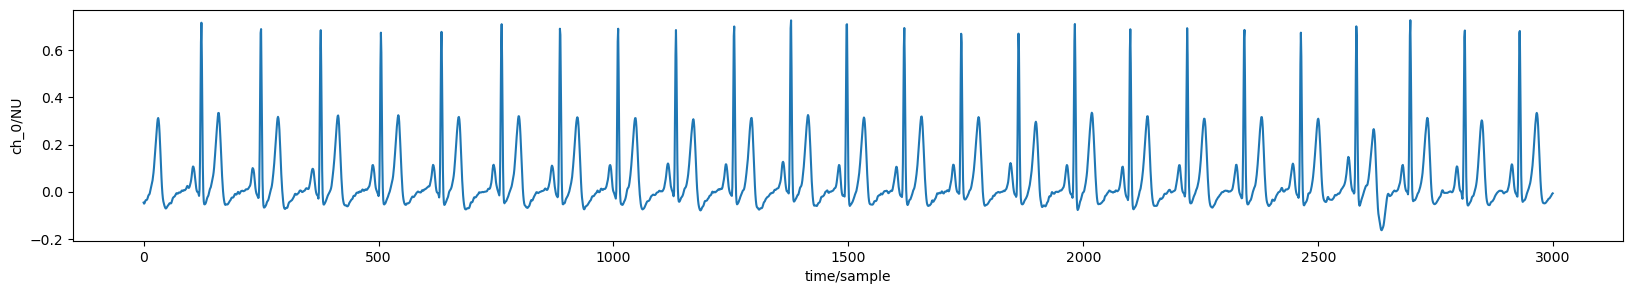

In [28]:
wfdb.plot_items(signal= lowpassed[2500 : 5500], fs= fields['fs'], figsize= (20, 3))

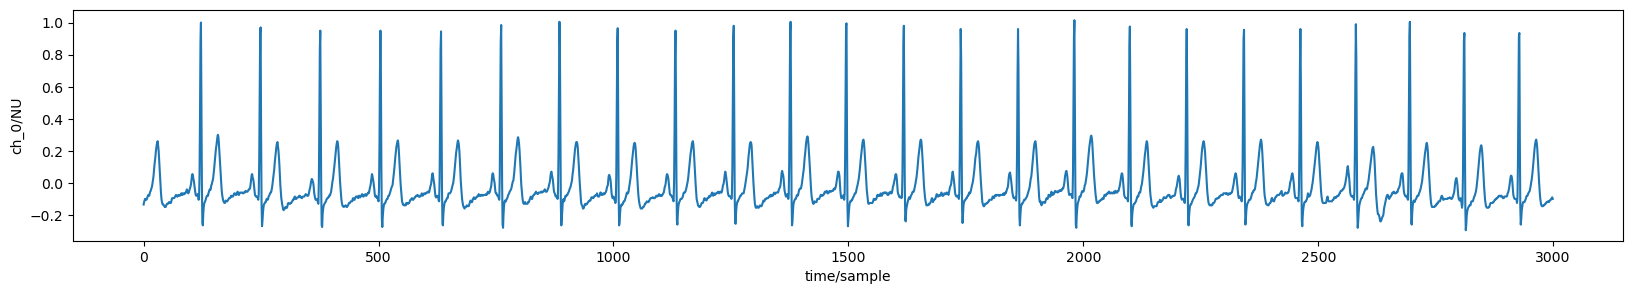

In [29]:
wfdb.plot_items(signal= sig[2500 : 5500], fs= fields['fs'], figsize= (20, 3))